TO DO: Create a dataloader that performs the transition to 3channel image, or figure out how to load in a 1 channel architecture
Test: mixed precision

In [2]:
import fastbook
fastbook.setup_book()

In [40]:

from fastbook import *
from fastai.vision.widgets import *
import skimage
from skimage import io as skio
import numpy
from PIL import Image, ImageEnhance

In [4]:
path =Path("D:/pytorch/data/2D_FishYolk")
Path.BASE_PATH =path
image_list = (path/'OriginalImages').ls()


## Convert the input 16bit images into tensors from 0-1 using the min-max from the whole training batch. There could be issues here related to speckles and such

In [ ]:
#Potential problem here, the 16bit images is squished into a narrow float range before being normalized out to 0-1
#Attempting to use tensors for speed when scaling to 3D GB data

#added - add 3 columns and reshape to a 3channel image to make it easier to use with the fastai model batching
image_tensors = [tensor(skimage.img_as_float( np.transpose( np.repeat( np.asarray(Image.open(o))[:, :, np.newaxis], 3, axis=2), (2,0,1)) )) for o in image_list]


In [ ]:
#normalize the dataset to min-max
stacked_images_tensor = torch.stack(image_tensors)
stacked_images_tensor.shape
max = torch.max(stacked_images_tensor)
min = torch.min(stacked_images_tensor)
#considering min*0.98 and max*0.98 to reduce error from speckles
normal_stacked_images_tensor = (stacked_images_tensor-min)/(max-min)
# df = pd.DataFrame(image1_tensor)
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

In [ ]:
##########################################
## Replace this all with a better dataloader
## Requires dummy files to be in place in the images folder
#########################################

numpy_array = [(o.numpy()*255).astype(numpy.uint8) for o in normal_stacked_images_tensor]

from tifffile import imsave
image_list_output = (path/'images').ls()
zippy = zip(image_list_output, (numpy_array))
#list(zippy)
[imsave(str(a),b) for a,b in zippy]

In [ ]:
#model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=8)

In [24]:
import fastbook
fastbook.setup_book()
from fastbook import *
path =Path("D:/pytorch/data/2D_FishYolk")
codes = ['Background','Zebrafish', 'Yolk']
#codes = np.loadtxt(path/'codes.txt', dtype='<U17')
def get_label_filename(name): return path/'labels'/f'{name.stem}_annotationLabels.tif'
dls = SegmentationDataLoaders.from_label_func(
    path, bs=4, fnames = get_image_files(path/"images"),
    label_func = get_label_filename,
    valid_pct=0.3,
    seed=42,
    codes = codes, num_workers=0
)

learn = unet_learner(dls, resnet34,loss_func =DiceLoss(), lr=0.01).to_fp16()


In [ ]:
#learn.fine_tune(50)
learn.unfreeze
learn.fit_one_cycle(150, lr_max=slice(1e-6, 5e-2))

In [37]:
learn.export('fish_yolk_segmentation_20220619.pkl')

In [ ]:
learn.fine_tune(50)
learn.unfreeze
learn.fit_one_cycle(150, lr_max=slice(1e-6, 1e-3))


In [14]:
learn.export()

In [ ]:
learn.unfreeze
learn.fit_one_cycle(8, lr_max=slice(1e-6, 1e-3))

In [25]:
learn.load("morning_100").to_fp16()

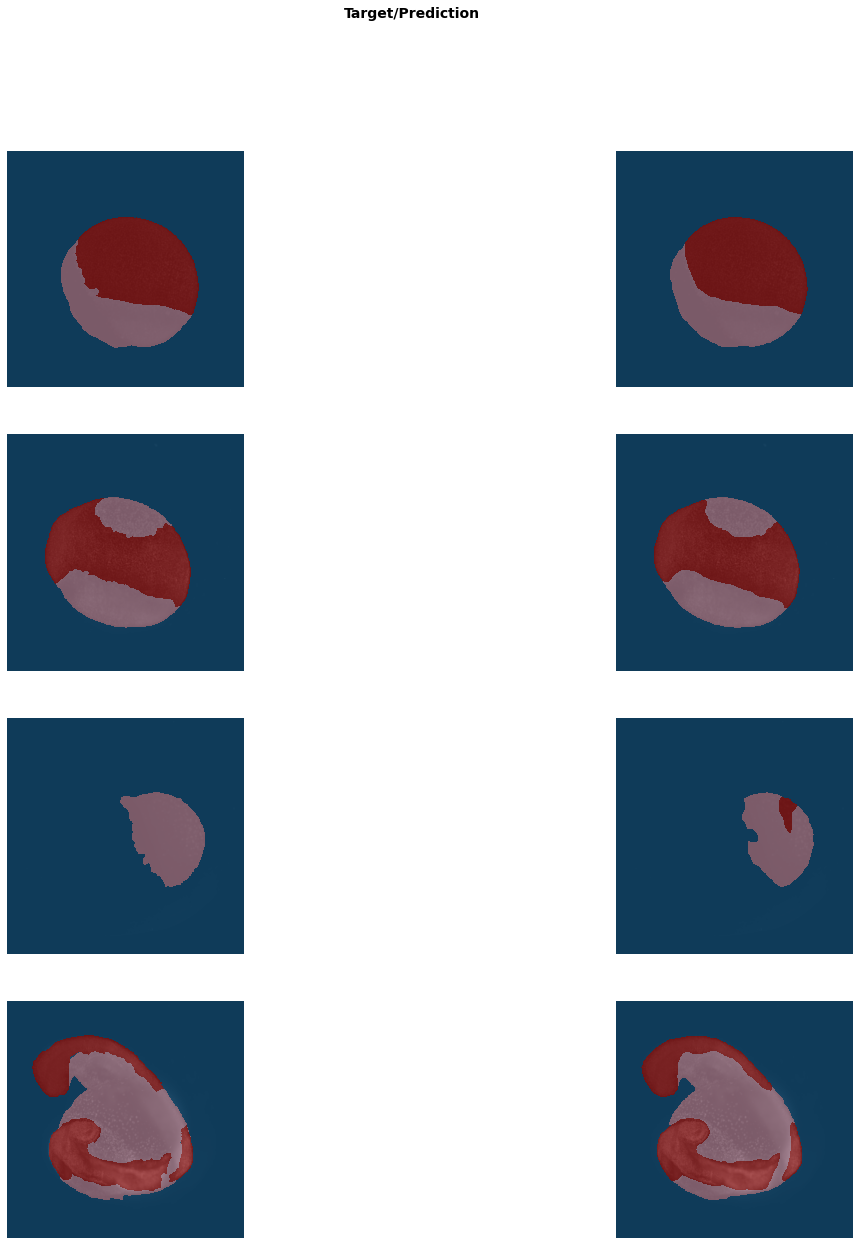

In [26]:
learn.show_results(max_n=4, figsize=(20,20))

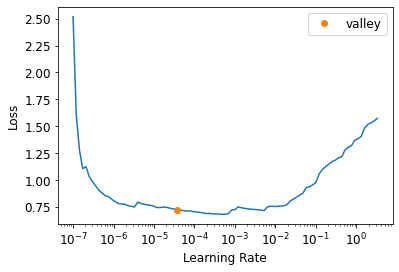

In [15]:
lr_steep = learn.lr_find()

In [ ]:
from fastai.test_utils import show_install
show_install()

D:\pytorch\data\2D_FishYolk\images\embryo11_011.tif


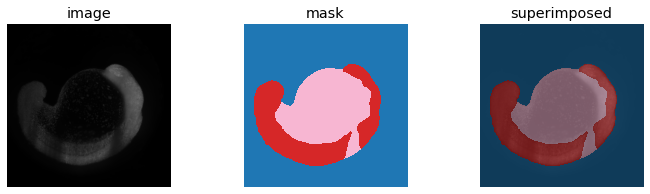

In [27]:
#Pick any image to get a prediction
n=26
fnames = get_image_files(path/"images")
img = PILImage.create(fnames[n])
zebrafish_classifier = load_learner(path/'export.pkl')
#zebrafish_classifier.load('valid_loss_1')
pred,pred_idx,probs = zebrafish_classifier.predict(fnames[n])
#img2 =Image.fromarray(pred.numpy())
#img2.show()
print(fnames[n])
_,axs = plt.subplots(1,3, figsize=(12,3))
img.show(ctx=axs[0], title='image')
pred.show(alpha=1, ctx=axs[1], vmin=0, vmax=3, title='mask')
img.show(ctx=axs[2], title='superimposed')
pred.show(ctx=axs[2], vmin=0, vmax=3);

In [29]:
btn_upload= widgets.FileUpload()
btn_upload


FileUpload(value={}, description='Upload')

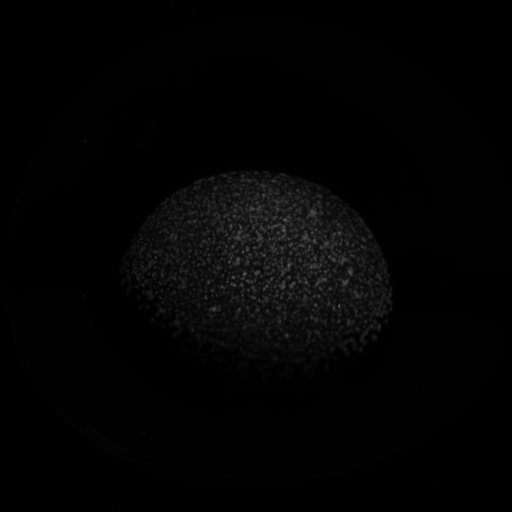

In [31]:
img = PILImage.create(btn_upload.data[-1])
img

In [32]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [34]:
zebrafish_classifier = load_learner(path/'export.pkl')
pred,pred_idx,probs = zebrafish_classifier.predict(img)

In [42]:

out_pl = widgets.Output()
out_pl_mask = widgets.Output()
lbl_pred = widgets.Label()
zebrafish_classifier = load_learner(path/'export.pkl')
btn_run = widgets.Button(description='Process')
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    enhancer = ImageEnhance.Brightness(img)
    factor = 10 
    im_output = enhancer.enhance(factor)
    with out_pl: display(im_output.to_thumb(128,128))
        
    pred,pred_idx,probs=zebrafish_classifier.predict(img)
    with out_pl_mask: pred.show(alpha=1, vmin=0, vmax=3, title='mask')
    
    #lbl_pred.value = f'Predicted age: {age[0]};'

btn_run.on_click(on_click_classify)


In [43]:
btn_upload= widgets.FileUpload()

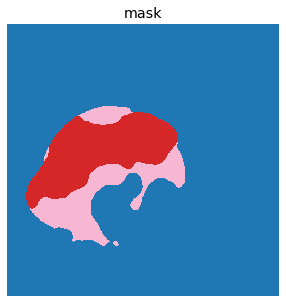

In [44]:
VBox([widgets.Label('Upload a grayscale zebrafish embryo image'), 
      btn_upload, btn_run, out_pl, out_pl_mask])

In [ ]:
cam_img = PILImage.create(img_f)
test_eq(cam_img.size, (512,512))
tmask = Transform(PILMask.create)
mask = tmask(lbl_f)
test_eq(type(mask), PILMask)
test_eq(mask.size, (512,512))
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=0, vmax=3, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=0, vmax=3);

get_y_fn = lambda o: path/'labels'/f'{o.stem}_annotationLabels.tif'
def get_label_filename(name, path): return path/'labels'/f'{name.stem}_annotationLabels.tif'